# Deep Learning with Python

## 6.4 Sequence processing with convnets

> 用卷积神经网络处理序列

卷积神经网络可以有效利用数据，提取局部特征，将表示模块化。由于这种特效，CNN 不但善于处理计算机时间问题，也可以高效处理序列问题，在有些序列问题上，CNN 的效果、效率甚至可以超过 RNN。

不同于处理图像用的二维 Conv2D，时间序列是一维的，所以要用一维卷积神经网络来处理。

### 序列数据的一维卷积、池化

和二维的卷积类似，一维卷积从序列中提取局部的片段（子序列），然后对每个片段做相同的变换。一维的卷积窗口是时间轴上的一维窗口。该运算的性质可以保证，在前面某个位置学到的模式稍后可以在其他位置被识出来（具有时间平移不变性）。

![一维卷积神经网络的工作原理:每个输出时间步都是利用输入序列在时间维度上的一小段得到的](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghmwvss1ibj317a0msn02.jpg)


一维的池化运算，也和二维池化运算类似：从输入中提取一维片段，输出其中的最大值(最大池化)或平均值(平均池化)。该运算也是用来降低数据的长度的(做子采样)。

### 实现一维卷积神经网络

在 Keras 中，一维卷积神经网络用 Conv1D 层来表示。用法和 Conv2D 很类似，它接收形状为 `(samples, time, features)` 的输入，返回还是这个形状的。注意，它的窗口是在 time 上的，即输入的第二个轴。Conv2D 里我们的窗口一般用 3x3、5x5 这样的，对应的 Conv1D 里，我们一般取 7 或 9 的窗口大小。

常情况下，我们都将 Conv1D 层和 MaxPooling1D 层堆叠在一起，在所有卷积池化堆叠的最后，再用一个全局池化运算或展平的操作。

还是以 IMDB 为例：

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [2]:
# 绘制历史

import matplotlib.pyplot as plt

def plot_acc_and_loss(history):

    epochs = range(len(history.history['loss']))

    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, 'bo-', label='Training acc')
        plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
    except:
        print('No acc. Skip')
    finally:
        plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

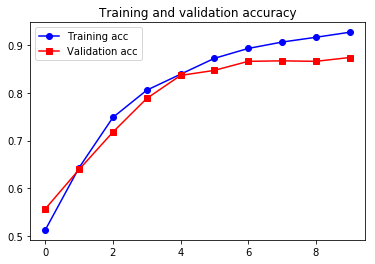

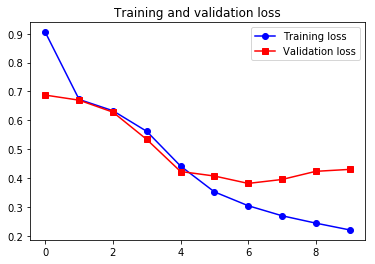

In [3]:
# 在 IMDB 上训练并评估一个简单的一维卷积神经网络

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))

model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

plot_acc_and_loss(history)

虽然结果略比 RNN 差，但还是挺不错的，而且训练起来比 LSTM 快。

### 结合 CNN 和 RNN 处理长序列

一维卷积神经网络是把序列分成片段去学习的，对时间顺序不敏感。所以对于那些序列的顺序影响重大的问题来说，CNN 表现的远不如 RNN。例如，耶拿数据集(气温预测)问题：

In [5]:
# 准备数据

import os
import numpy as np

data_dir = "/Volumes/WD/Files/dataset/jena_climate"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 27s 54ms/step - loss: 0.4144 - val_loss: 0.4308
Epoch 2/20
500/500 [==============================] - 26s 52ms/step - loss: 0.3620 - val_loss: 0.4306
Epoch 3/20
500/500 [==============================] - 23s 45ms/step - loss: 0.3367 - val_loss: 0.4340
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 0.3220 - val_loss: 0.4492
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.3119 - val_loss: 0.4504
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3009 - val_loss: 0.4411
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2940 - val_loss: 0.4398
Epoch 8/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2861 - val_loss: 0.4523
Epoch 9/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2822 - val_loss: 0.4502
Epoch 

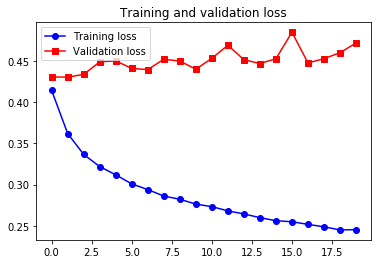

In [6]:
# 在耶拿数据集上训练并评估一个简单的一维卷积神经网络

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_acc_and_loss(history)

这还不如咱用的那个常识法呢，可见顺序信息对这个问题还是非常关键的。为了学到顺序上的信息，同时保持卷积神经网络的速度和轻量，我们可以结合使用 CNN 和 RNN。

我们可以在 RNN 前面使用 Conv1D。对于非常长的序列 (比如包含上千个时间步)，直接用 RNN 处理起来太慢、甚至无法处理。在 RNN 前面加上一些 Conv1D 就可以把过长的输入序列转换(下采样)为由高级特征组成的更短序列，然后再用 RNN 去处理有可以学到顺序敏感的信息。

![结合一维 CNN 和 RNN 来处理长序列](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghmy56fkp4j30ji0ncgni.jpg)

我们用这种方法再做一次气温预测问题，由于这种方法可以学习更长的序列，我们可以让网络查看更早的数据(增大数据生成器的 lookback 参数)，也可以让网络查看分辨率更高的时间序列（减小生成器的 step 参数）：

In [7]:
step = 3  # 30 分钟一步，比以前缩短了一半
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 49s 97ms/step - loss: 0.3301 - val_loss: 0.3056
Epoch 2/20
500

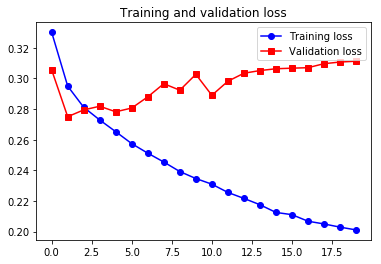

In [8]:
# 用 Conv1D + GRU

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_acc_and_loss(history)

从验证损失来看，这种架构的效果不如只用正则化 GRU，但速度要快很多。它查看了两倍的数据量，在本例中可能不是非常有用，但对于其他数据集可能非常重要。